In [1]:
# !pip3 uninstall PIL
# !pip3 install --upgrade pip tensorflow
# !pip3 install --upgrade --force-reinstall matplotlib pillow

# Imports
import tensorflow as tf
# import cupy as cp
import numpy as np
from tensorflow import keras
# import PIL
# from pillow import Image
# import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib inline
# from tensorflow.keras import layers
# from tensorflow.keras import Input
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import *
import tempfile

print("Reg Train Keras version: ", keras.__version__)
print("Reg Train TF version: ", tf.__version__)

from ml_library.model import *
from ml_library.utils import *
from ml_library.config import *
from ml_library.w_utils import *

import warnings
warnings.filterwarnings("ignore")

model_dir = './models/'
#tmpdir = tempfile.mkdtemp()
#print("Tmpdir = ", tmpdir)
print("model_dir = ", model_dir)


# Load the TensorBoard notebook extension
%load_ext tensorboard


Reg Train Keras version:  2.7.0
Reg Train TF version:  2.7.0
Tmpdir =  C:\Users\akomm\AppData\Local\Temp\tmp30k2qag3


# Import Dataset

In [2]:

importDatasets()


# Load data
training_file = "./Datasets/GTSRB_Final_Training_Images.zip"
# testing_file = "./Datasets/GTSRB_Final_Test_Images.zip"

train = generateTensor(training_file)
# test = generateTensor(testing_file)

x_train, y_train = split(train)
# x_test, y_test = split(test)


Training file:  True
Test file:  True


Train size: 31367 Validation size: 7842 (0.200)
No classes: 43


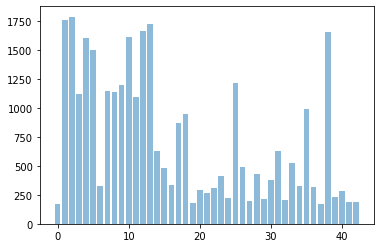

x_train shape: (31367, 32, 32, 3)
y_train shape: (31367,)
x_val shape: (7842, 32, 32, 3)
y_val shape: (7842,)


In [3]:

from sklearn.model_selection import train_test_split
label_map = map_labels('signnames.csv')

file_paths = len(x_train)
from ml_library.model import *
#Train/validation split
x_train, x_val, y_train, y_val = train_test_split(
    np.asarray(x_train), np.asarray(y_train), test_size=VALIDATION_SIZE)


valid_ratio = len(x_val) / file_paths
print("Train size: {} Validation size: {} ({:0.3f})".format(
    len(x_train),
    len(x_val),
    valid_ratio))

classes, dist = np.unique(y_train, return_counts=True)
NUM_CLASSES = len(classes)
print("No classes: {}".format(NUM_CLASSES))

plt.bar(classes, dist, align='center', alpha=0.5)
plt.show()


print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
# print("x_test shape:", x_test.shape)
# print("y_test shape:", y_test.shape)


In [4]:
import datetime
from ml_library.model import *
from ml_library.config import *

# original_dim = 784
original_dim = IMG_SIZE*IMG_SIZE
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
mse_loss_fn = tf.keras.losses.MeanSquaredError()

loss_metric = tf.keras.metrics.Mean()
# Define our metrics
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')
val_loss = tf.keras.metrics.Mean('val_loss', dtype=tf.float32)
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('val_accuracy')

# First, let's create a training Dataset instance.
# For the sake of our example, we'll use the same MNIST data as before.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

# # Now we get a test dataset.
# test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
# test_dataset = test_dataset.batch(64)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(
    1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

vae_ds = tf.data.Dataset.from_tensor_slices(x_train)
vae_ds = vae_ds.shuffle(buffer_size=1024).batch(64)
# vae_ds = vae_ds.cache().shuffle(
#     1000).prefetch(buffer_size=AUTOTUNE)

vae = VariationalAutoEncoder(original_dim, 64, 32)
vae.compile(optimizer, loss= mse_loss_fn, metrics= loss_metric)

# Clear any logs from previous runs
# !rm - rf ./logs/fit/vae

log_dir = "logs/fit/vae" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)

# vae.fit(x=x_train, y=x_train, epochs=NUM_EPOCH, validation_data=(x_val, x_val), callbacks=[tensorboard_callback], batch_size=64, verbose=1)


# epochs = NUM_EPOCH

# # Iterate over epochs.
# for epoch in range(epochs):
#     print("Start of epoch %d" % (epoch,))

#     # Iterate over the batches of the dataset.
#     for step, x_batch_train in enumerate(vae_ds):
#         with tf.GradientTape() as tape:
#             reconstructed = vae(x_batch_train)
#             # Compute reconstruction loss
#             loss = mse_loss_fn(x_batch_train, reconstructed)
#             loss += sum(vae.losses)  # Add KLD regularization loss

#         grads = tape.gradient(loss, vae.trainable_weights)
#         optimizer.apply_gradients(zip(grads, vae.trainable_weights))

#         loss_metric(loss)

#         if step % 100 == 0:
#             print("step %d: mean loss = %.4f" % (step, loss_metric.result()))


# vae.evaluate(x_val, x_val, verbose=1)
# model_path = os.path.join(model_dir, 'normal_vae')
# print('Saving model...')
# vae.save(model_path)
# # tf.saved_model.save(vae, model_path)


1024
1024


Train Normal Model

In [9]:
import datetime
from ml_library.model import *
from ml_library.config import *


# normal_model = get_compiled_model(REIN=False)
###################
# https://keras.io/guides/sequential_model/ example code
#def get_uncompiled_model(REIN=False):
if True:
    inputs = keras.Input(
        shape=(IMG_SIZE, IMG_SIZE, NUM_CHANNELS), name="inputs")
    model = keras.Sequential()
    # model.add(inputs)
    # model.add(resize_and_rescale)

    # # REIN Data Augmentation
    # if(REIN):
    #     model.add(data_augmentation)

    model.add(Conv2D(16, 3, padding='same', activation='gelu'))
    # model.add(BatchNormalization)
    model.add(MaxPooling2D())
    model.add(Conv2D(64, 3, strides=(3, 3), padding='same', activation='gelu'))
    # model.add(BatchNormalization)
    model.add(MaxPooling2D())
    model.add(Conv2D(128, 3, padding='same', activation='gelu'))
    # model.add(BatchNormalization)
    model.add(Conv2D(128, 3, padding='same', activation='gelu'))
    # model.add(BatchNormalization)
    model.add(MaxPooling2D())
    model.add(layers.Flatten())

    # FC Layers w/ Dropout
    model.add(Dense(1024, activation='gelu'))
    model.add(Dropout(RATE))
    model.add(Dense(1024, activation='gelu'))
    model.add(Dropout(RATE))

    model.add(Dense(NUM_CLASSES, activation="softmax", name="predictions"))

    outputs = model.get_layer(name="predictions").output
    # build model
    model2 = keras.Model(inputs=inputs, outputs=outputs)
    
    model = model2
    #return model


#def get_compiled_model(REIN=False):
if True:
    #model = get_uncompiled_model(REIN)

    # model.compile(
    #     optimizer="rmsprop",
    #     loss="sparse_categorical_crossentropy",
    #     metrics=["sparse_categorical_accuracy"],
    # )

    model.summary()
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(
                      from_logits=True),
                  metrics=['accuracy'])
    #return model

    normal_model = model
##################

# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
# hist_norm = normal_model.fit([vae.predict(x_train), y_train], validation_data=val_dataset,
#                              validation_steps=10, epochs=NUM_EPOCH, verbose=1)
hist_norm = normal_model.fit(train_dataset, validation_data=val_dataset,
                             validation_steps=10, epochs=NUM_EPOCH, verbose=1)

# Evaluate the model
print("Evaluate")
result_normal = normal_model.evaluate(val_dataset)
dict(zip(normal_model.metrics_names, result_normal))


model_path = os.path.join(model_dir, 'normal_model')
normal_model_path = model_path
print('Saving model...')
normal_model.save(model_path)
# tf.saved_model.save(normal_model, model_path)
print('Saved model.')


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 6, 6, 64)          9280      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 3, 3, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 3, 3, 128)         7385

Train REIN Model

In [10]:

# vae = VariationalAutoEncoder(original_dim, IMG_SIZE*2, IMG_SIZE, REIN=True)
# vae.compile(optimizer, loss=mse_loss_fn, metrics=loss_metric)
# vae.fit(x_train, x_train, epochs=NUM_EPOCH,  batch_size=64, verbose=1)
# vae.evaluate(x_val, x_val, verbose=1)

# model_path = os.path.join(model_dir, 'rein_vae')
# print('Saving model...')
# vae.save(model_path)
# tf.saved_model.save(vae, model_path)


In [11]:

# skip REIN model for now
if False:
    rein_model = get_compiled_model(REIN=True)


    # Since the dataset already takes care of batching,
    # we don't pass a `batch_size` argument.
    # hist_rein = rein_model.fit(vae.predict(train_dataset), validation_data=val_dataset,
    #                            validation_steps=10, epochs=NUM_EPOCH, verbose=1)
    hist_rein = rein_model.fit(train_dataset, validation_data=val_dataset,
                            validation_steps=10, epochs=NUM_EPOCH, verbose=1)

    # Evaluate the model
    print("Evaluate")
    result_rein = rein_model.evaluate(val_dataset)
    dict(zip(rein_model.metrics_names, result_rein))


    model_path = os.path.join(model_dir, 'rein_model')
    rein_model_path = model_path
    print('Saving model...')
    rein_model.save(model_path)
    # tf.saved_model.save(rein_model, rein_model_path)


In [12]:
# def visualize(original, augmented):
#   fig = plt.figure()
#   plt.subplot(1, 2, 1)
#   plt.title('Original image')
#   plt.imshow(original)

#   plt.subplot(1, 2, 2)
#   plt.title('Augmented image')
#   plt.imshow(augmented)


# image, label = next(iter(train_dataset))
# _ = plt.imshow(image)
# _ = plt.title(get_label_name(label))

# flipped = tf.image.flip_left_right(image)
# visualize(image, flipped)

# grayscaled = tf.image.rgb_to_grayscale(image)
# visualize(image, tf.squeeze(grayscaled))
# _ = plt.colorbar()


# saturated = tf.image.adjust_saturation(image, 3)
# visualize(image, saturated)


# bright = tf.image.adjust_brightness(image, 0.4)
# visualize(image, bright)


# cropped = tf.image.central_crop(image, central_fraction=0.5)
# visualize(image, cropped)

# rotated = tf.image.rot90(image)
# visualize(image, rotated)


## Testing

x_test= 12569
y_test= 12569
Predictions


ValueError: in user code:

    File "C:\Users\akomm\.conda\envs\tf-gpu-38\lib\site-packages\keras\engine\training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\akomm\.conda\envs\tf-gpu-38\lib\site-packages\keras\engine\training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\akomm\.conda\envs\tf-gpu-38\lib\site-packages\keras\engine\training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\akomm\.conda\envs\tf-gpu-38\lib\site-packages\keras\engine\training.py", line 1572, in predict_step
        return self(x, training=False)
    File "C:\Users\akomm\.conda\envs\tf-gpu-38\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\akomm\.conda\envs\tf-gpu-38\lib\site-packages\keras\engine\input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_2" is incompatible with the layer: expected shape=(None, 32, 32, 3), found shape=(32, 32, 3)


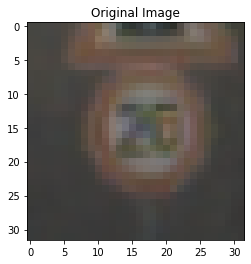

In [42]:

# Imports
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
# %matplotlib inline

# print("Reg Train Keras version: ", keras.__version__)
# print("Reg Train TF version: ", tf.__version__)

from ml_library.config import *
from ml_library.utils import *
from ml_library.model import *
#from ml_library.w_utils import *

import warnings
warnings.filterwarnings("ignore")

# testing_file = './Datasets/GTSRB_Final_Test_Images.zip'
testing_file = './Datasets/GTSRB_Online-Test-Images-Sorted.zip'
test = generateTensor(testing_file, False)
x_test, y_test = test['features'], test['labels']
print("x_test=", len(x_test))
print("y_test=", len(y_test))
#x_test, y_test = preprocess_data(x_test, y_test)
#################

x = x_test
y = y_test
if False:
#def preprocess_data(x, y):
    """
    Preprocess image data, and convert labels into one-hot

    Arguments:
        * x: Image data
        * y: Labels

    Returns:
        * Preprocessed x, one-hot version of y
    """
    # Convert from RGB to grayscale if applicable
    if GRAYSCALE:
        x = rgb_to_gray(x)

    # Make all image array values fall within the range -1 to 1
    # Note all values in original images are between 0 and 255, as uint8
    x = x.astype('float32')
    x = (x - 128.) / 128.

    # Convert the labels from numerical labels to one-hot encoded labels
    y_onehot = np.zeros((y.shape[0], NUM_CLASSES))
    for i, onehot_label in enumerate(y_onehot):
        onehot_label[y[i]] = 1.
    y = y_onehot

    x_test = x
    y_test = y

    #return x, y

#################
# print("x_test shape:", x_test.shape)
# print("y_test shape:", y_test.shape)

# normal_model_path = r"C:\Users\akomm\AppData\Local\Temp\tmp4wcvqiyg\normal_model"
normal_model_path = r"C:\Users\akomm\AppData\Local\Temp\tmp30k2qag3\normal_model"

# # model_path = normal_model_path
# model_path = rein_model_path
# model = tf.saved_model.load(model_path)
# adv_acc = model.evaluate()

if True:    # no need of session in TF2
#with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    
    model_path = normal_model_path
    # model_path = rein_model_path
    #model = tf.saved_model.load(model_path)

    # https://githubmemory.com/repo/tensorflow/decision-forests/issues/25
    model = tf.keras.models.load_model(model_path)
    print(model)

    # Prepare the validation dataset
    # test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    # test_dataset = test_dataset.batch(64)
    
    #print("Evaluate")
    #acc = model.evaluate(test_dataset)

    # image = x_test[np.random.randint(len(x_test))]
    image = x_test[:3]

    # Show original image for reference
    # plt.subplot(3, 3, 1)
    plt.imshow(image[1])
    plt.title('Original Image')

    # for i in range(9):
    #     image_x = transform_image(image, ANGLE, TRANSLATION, WARP)
    #     plt.subplot(3, 3, i+2)
    #     plt.imshow(image_x)
    #     plt.title('Transformed Image %d' % (i+1,))

    # plt.tight_layout()
    # plt.show()

    #image = x_test[1:2]
    
    img = image[1]
    print("Predictions")
    prediction = model.predict(img)
    print("Image Prediction: ", prediction)
    # prediction = model.predict(image_x)
    # print("Image Prediction: ", prediction)
    # print("Test Set Accuracy = {:.3f}".format(acc))


    for i in range(20):
        rain_images = rain(x_test, i)
        adv_acc = model.evaluate(rain_images, y_test)
        print("Rain Drops %.2d  vs. Accuracy vs Adv_Accuracy：" % i, acc, adv_acc)
    
    for i in range(20):
        rain_images = fog(x_test, i)
        adv_acc = model.evaluate(rain_images, y_test)
        print("fog Drops %.2d  vs. Accuracy vs Adv_Accuracy：" % i, acc, adv_acc)
    
    for i in range(20):
        rain_images = light(x_test, i)
        adv_acc = model.evaluate(rain_images, y_test)
        print("light Drops %.2d  vs. Accuracy vs Adv_Accuracy：" %
              i, acc, adv_acc)
    
    for i in range(20):
        rain_images = dark(x_test, i)
        adv_acc = model.evaluate(rain_images, y_test)
        print("dark Drops %.2d  vs. Accuracy vs Adv_Accuracy：" % i, acc, adv_acc)
    
    for i in range(20):
        rain_images = blur(x_test, i)
        adv_acc = model.evaluate(rain_images, y_test)
        print("Blur deviation %.2d  vs. Accuracy vs Adv_Accuracy：" %
              i, acc, adv_acc)
